<div style="text-align: center; background-color: #0A6EBD; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
    FIT-HCMUS, VNU-HCM 
    <br>
    Introduction To Data Science 
    <br>
    Final project 📌
</div>

<div style="text-align: center; background-color: #5A96E3; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  Stage 04 - Data Modelling 📌
</div>

##  Problem statement


- **Stating problem**: In the realm of professional football, accurately assessing and predicting a player's performance remains a challenging task. Coaches, managers, and scouts often rely on subjective evaluations and historical data, but there is a growing need for a more sophisticated and data-driven approach to player performance prediction. To address this gap, the problem at hand is to develop a robust predictive model that can accurately forecast the performance of a football player based on various factors, including but not limited to fitness levels, historical performance stats, injury history and situational context.
- **Purposes/benefits** of solving the problem:
    - Successful predictive model would revolutionize the player recruitment process, allowing teams to identify talent more efficiently. By evaluating the potential performance of players based on objective data, teams can make more informed decisions in the transfer market, minimizing risks and maximizing the likelihood of acquiring valuable assets.
    - Coaches can leverage the predictive model to tailor their strategies and game plans based on the expected performance of individual players. This can lead to more effective and adaptive team strategies, optimizing player positions, substitutions, and tactical approaches during matches.
    - The model's insights can be used by coaches and sports scientists to design personalized training programs for players. Tailoring training regimens based on predicted performance metrics can contribute to individual player development and overall team improvement.
- **Approach**: In this section, we explore the application of three different models to address this problem, including `Ridge Linear Regression`, `Random Forest`, `Neural Network`. A final comparison of the results will be conducted to determine the most suitable model for solving this particular problem.

## Set up enviroment

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import time
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.feature_selection import SequentialFeatureSelector

## Data preparation

**reading data**

In [46]:
df = pd.read_csv('../../data/processed/encoded_data.csv')
# df = pd.read_csv('../../data/processed/scaled_encoded_data.csv')
df.head()

,Age,LgRank,MP,Starts,Min,90s,Gls,Ast,G+A,G-PK,...,npxG+xAG/90,Injury,Days,Games missed,Position_DF,Position_FW,Position_MF,PreferredFoot_ Both,PreferredFoot_ Left,PreferredFoot_ Right
0,17,4,16,13,1277,14.2,0,0,0,0,...,0.020000,1,128.0,22.0,1,0,0,0,0,1
1,18,17,12,11,992,11.0,0,0,0,0,...,0.030000,1,77.0,19.0,1,0,0,0,0,1
2,19,9,26,26,2326,12.9,1,0,1,1,...,0.088306,0,0.0,0.0,1,0,0,0,0,1
3,19,10,26,26,2326,12.9,1,0,1,1,...,0.088306,0,0.0,0.0,1,0,0,0,0,1
4,20,2,36,36,3240,36.0,0,0,0,0,...,0.060000,0,0.0,0.0,1,0,0,0,0,1


### Preprocess

**Extracting necessary features**

In [47]:
# ----------------------------------Random Forest----------------------------------
X_rf = df.drop(['Gls', 'Ast', 'G+A', 'Gls/90', 'Ast/90', 'G+A/90'], axis=1)
y_rf = df['G+A']

In [48]:
# ----------------------------------Ridge Linear Regression----------------------------------
X_rlr = df.drop(['G+A','Gls','Ast','Gls/90','Ast/90','G+A/90'],axis='columns')
Y_rlr = df['G+A']

### Spliting train - validation - test set

- For `Random Forest`, we consider the proportion of train-validation-test is 70-15-15.

In [49]:
# ----------------------------------Random Forest----------------------------------
# train-validation-test proportion: 70-15-15
X_rf_train, X_rf_temp, y_rf_train, y_rf_temp = train_test_split(X_rf, y_rf, test_size=0.3, random_state=42)
X_rf_validation, X_rf_test, y_rf_validation, y_rf_test = train_test_split(X_rf_temp, y_rf_temp, test_size=0.5, random_state=42)

- For `Ridge Linear Regression`, we consider the proportion of train-test is 80-20.

In [50]:
# ----------------------------------Ridge Linear Regression----------------------------------
X_rlr_train, X_rlr_test, Y_rlr_train, Y_rlr_test = train_test_split(X_rlr, Y_rlr, train_size=0.8,shuffle=True,
                                                        random_state=0)

## Create models

- We use `RandomizedSearchCV` to search through the hyperparameter space defined in `param_dist` and find the best combination of hyperparameters for the model. The parameters is defined as below:
    - `n_estimators`: The number of trees in the forest.
    - `max_depth`: The maximum depth of the trees in the forest.
    - `min_samples_split`: The minimum number of samples required to split an internal node.
    - `min_samples_leaf`: The minimum number of samples required to be at a leaf node.
    - `max_features`: The number of features to consider when looking for the best split.


In [51]:
# ----------------------------------Random Forest----------------------------------
# Define the hyperparameter grid
param_dist = {
    'n_estimators': [int(x) for x in np.linspace(start=50, stop=200, num=10)],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Create Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Perform RandomizedSearchCV with cross-validation
random_search = RandomizedSearchCV(
    rf_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42
)

- We use `GridSearchCV` to search through the hyperparameter space defined in `param_grid` and find the best combination of hyperparameters for the model. The parameters in the `GridSearchCV` is defined as below:
    - `estimator`: The model which is used to train to find the best combination of hyperparameters.
    - `param_grid`: The dictionary with keys are parameters in model and values is a list of each parameters.
    - `scoring`: The score to judge which combination is the best .
    - `cv`: The number of fold in cross-validation . In this case , it will split training dataset to 5 folds , 4 folds for training and 1 fold for validating

- The parameters are defined in the parameters dictionary is :
    - `alpha`: Constant that multiplies the L2 regularization
    - `fit_intercept`: The decision to intercept the model or not 
    - `max_iter`: The maximum number of iterations for the solver
    - `solver`: The solver to use is way to find coefficients for each feature

In [52]:
# ----------------------------------Ridge Linear Regression----------------------------------
# Define the hyperparameter grid
param_grid = {
    'alpha' : [1e-3,1e-2,1e-1,1,10],
    'fit_intercept' : [True,False],
    'max_iter':[500,1000,1500,2000],
    'solver':['svd','cholesky']
}
# Create Ridge Linear Regression model
ridge_model = Ridge()
# Perform GridSearchCV with cross-validation
ridge_grid = GridSearchCV(estimator=ridge_model,param_grid=param_grid,scoring='r2',cv=5)

## Training phase 

### Training models

In [53]:
# ----------------------------------Random Forest----------------------------------
# Fit the RandomizedSearchCV to find the best hyperparameters
rf_t1_para = time.time()

random_search.fit(X_rf_train, y_rf_train)

rf_t2_para = time.time()
running_time_para_rf = rf_t2_para-rf_t1_para

# Get the best hyperparameters
best_params_random = random_search.best_params_

# Print the best hyperparameters
print("Best Hyperparameters:")
for key, value in zip(best_params_random.keys(), best_params_random.values()):
    print(f'   {key}: {value}')

print(f'Running time for tuning hyperparameters for Random Forest : {running_time_para_rf}')

best_rf_model = random_search.best_estimator_

Best Hyperparameters:
   n_estimators: 50
   min_samples_split: 10
   min_samples_leaf: 2
   max_features: None
   max_depth: 15
Running time for tuning hyperparameters for Random Forest : 48.58025622367859


In [54]:
# ----------------------------------Ridge Linear Regression----------------------------------
# Fit the RandomizedSearchCV to find the best hyperparameters
rlr_t1_para = time.time()

ridge_grid.fit(X_rlr_train, Y_rlr_train)

rlr_t2_para = time.time()
running_time_para_rlr = rlr_t2_para-rlr_t1_para
# Get the best hyperparameters
best_params_grid = ridge_grid.best_params_
# Print the best hyperparameters
print("Best Hyperparameters:")
for key, value in zip(best_params_grid.keys(), best_params_grid.values()):
    print(f'   {key}: {value}')
print(f'Running time for tuning hyperparameters for Ridge Linear Regression: {running_time_para_rlr}')
rlr_best_model = ridge_grid.best_estimator_

Best Hyperparameters:
   alpha: 10
   fit_intercept: False
   max_iter: 500
   solver: svd
Running time for tuning hyperparameters for Ridge Linear Regression: 2.8560478687286377


**Feature Engineering**

- Use `SequentialFeatureSelector` for extracting feature is good for prediction and reduce the time the model train

- The parameter in `SequentialFeatureSelector`:
    - `estimator`: The model which is used to train to find the best combination of hyperparameters.
    - `n_features_to_select`: The number of features to be selected , `auto` mean `SequentialFeatureSelector` select the number of features based on tol 
    - `scoring`: The score to judge which feature combination is the best .
    - `cv`: The number of fold in cross-validation . In this case , it will split training dataset to 5 folds , 4 folds for training and 1 fold for validating
    - `direction` : the number of feature to start with . `backward` mean the number of feature is all feature in train dataset 

In [55]:
sfs = SequentialFeatureSelector(estimator=rlr_best_model, n_features_to_select='auto',scoring='r2',direction='backward',tol=1e-3,cv=5)
sfs.fit(X_rlr_train, Y_rlr_train)
selected_features = sfs.get_support()
 
print('The selected features are:', (list(X_rlr_train.columns[selected_features])))

The selected features are: ['Age', 'LgRank', 'MP', 'Starts', 'Min', '90s', 'G-PK', 'PKatt', 'CrdY', 'CrdR', 'xG', 'npxG', 'xAG', 'npxG+xAG', 'PrgC', 'PrgP', 'PrgR', 'G-PK/90', 'xG/90', 'xAG/90', 'xG+xAG/90', 'npxG/90', 'npxG+xAG/90', 'Injury', 'Days', 'Games missed', 'Position_DF', 'Position_FW', 'Position_MF', 'PreferredFoot_ Both', 'PreferredFoot_ Left', 'PreferredFoot_ Right']


In [56]:
X_rlr_train =X_rlr_train.loc[:, selected_features]
X_rlr_test = X_rlr_test.loc[:, selected_features]

In [57]:
#Train the model again with the train dataset after finding the best combination of parameters
rlr_best_model.fit(X_rlr_train,Y_rlr_train)

Ridge(alpha=10, fit_intercept=False, max_iter=500, solver='svd')

### Evaluation

Given that our dataset has few outliers and the error has a limited impact on this problem, selecting Mean Absolute Error (MAE) emerges as the optimal metric. However, for additional insights, we also contemplate incorporating Mean Squared Error (MSE). Additionally, we opt for the R-squared score to gauge the overall goodness of fit and assess how well our Random Forest model captures the variability in the target variable.

In [58]:
# ----------------------------------Random Forest----------------------------------
y_rf_validation_pred_random = best_rf_model.predict(X_rf_validation)

# Evaluate the model on the validation set
mse_random = mean_squared_error(y_rf_validation, y_rf_validation_pred_random)
mae_random = mean_absolute_error(y_rf_validation, y_rf_validation_pred_random)
r2_random = r2_score(y_rf_validation, y_rf_validation_pred_random)

print('Validation Set Metrics:')
print(f'Mean Squared Error (MSE): {mse_random}')
print(f'Mean Absolute Error (MAE): {mae_random}')
print(f'R-squared Score: {r2_random}')

Validation Set Metrics:
Mean Squared Error (MSE): 4.760829061691066
Mean Absolute Error (MAE): 1.0538291084996663
R-squared Score: 0.942655102929453


## Testing phase 

### Testing models

In [59]:
# ----------------------------------Random Forest----------------------------------
y_rf_test_pred_random = best_rf_model.predict(X_rf_test)
test_mse_random = mean_squared_error(y_rf_test, y_rf_test_pred_random)
test_mae_random = mean_absolute_error(y_rf_test, y_rf_test_pred_random)
test_r2_random = r2_score(y_rf_test, y_rf_test_pred_random)

print('Test Set Metrics for Random Forest:')
print(f'Mean Squared Error (MSE): {test_mse_random}')
print(f'Mean Absolute Error (MAE): {test_mae_random}')
print(f'R-squared Score: {test_r2_random}')

Test Set Metrics for Random Forest:
Mean Squared Error (MSE): 5.305140435362749
Mean Absolute Error (MAE): 0.9849512542612242
R-squared Score: 0.9475989936311416


In [60]:
# ----------------------------------Ridge Linear Regression----------------------------------
Y_rlr_predict = rlr_best_model.predict(X_rlr_test)
test_mse_ridge = mean_squared_error(Y_rlr_test,Y_rlr_predict)
test_mae_ridge = mean_absolute_error(Y_rlr_test,Y_rlr_predict)
test_r2_ridge = r2_score(Y_rlr_predict,Y_rlr_test)
print('Test Set Metrics for Ridge Linear Regression:')
print(f'Mean Squared Error (MSE): {test_mse_ridge}')
print(f'Mean Absolute Error (MAE): {test_mae_ridge}')
print(f'R-squared Score: {test_r2_ridge}')

Test Set Metrics for Ridge Linear Regression:
Mean Squared Error (MSE): 6.2197498289530895
Mean Absolute Error (MAE): 1.5642353209529585
R-squared Score: 0.9268837074345534


**Visualize predicted vs actual output**

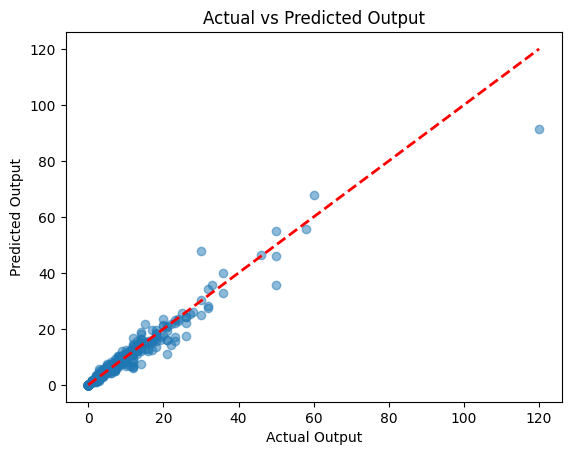

In [61]:
# ----------------------------------Random Forest----------------------------------
plt.scatter(y_rf_test, y_rf_test_pred_random, alpha=0.5)
plt.title('Actual vs Predicted Output')
plt.xlabel('Actual Output')
plt.ylabel('Predicted Output')

x_line = np.linspace(min(y_rf_test), max(y_rf_test), 100)
plt.plot(x_line, x_line, color='red', linestyle='--', linewidth=2)

plt.show()

**Observations**
- The model performs well on both the validation and test sets, as evidenced by low MSE and MAE values. Approximate 1 G+A error is a very impressive number.
- The R-squared scores (0.942 and 0.947) suggest that the model captures a substantial amount of variability in the target variable.
- The consistency between validation and test set metrics indicates good generalization of the model to new, unseen data.
- Based on the just-visualized chart of predicted outputs versus actual outputs, the scattered points exhibit a linear trend along the y=x line. This indicates that the model is performing quite well.

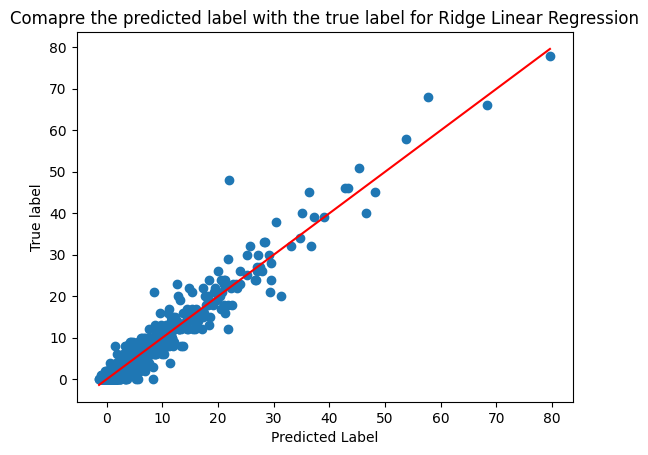

In [62]:
# ----------------------------------Ridge Linear Regression----------------------------------
plt.scatter(Y_rlr_predict,Y_rlr_test)

plt.xlabel("Predicted Label")
plt.ylabel("True label")
plt.title("Comapre the predicted label with the true label for Ridge Linear Regression")
y_line = np.linspace(min(Y_rlr_predict), max(Y_rlr_predict), 1000).reshape(-1, 1)
plt.plot(y_line,y_line, color='r')
plt.show()

**Observations**
- The model has a good predictions on test sets , with very low MAE values , about 1.5 G + A is good number
- The R-sqaured score : 0.926 show that the independent variables are passed into the model explain the majority of the target variable 
- From the chart showing the predicted output with the true output , the scatter plot show the linear trend between 2 axis with few outliers , it show that the model predicted quite well 

## Results analysis - Compare models

In [63]:
# YOUR CODE HERE
# Create a result DataFrame to compare between 2 models
result_df = pd.DataFrame()
result_df['Mean Squared Error'] = [test_mse_random,test_mse_ridge]
result_df['Mean Absolute Error'] = [test_mae_random,test_mae_ridge]
result_df['R squared'] = [test_r2_random,test_r2_ridge]
result_df['Running time for tuning hyperparameters'] = [running_time_para_rf,running_time_para_rlr]
result_df.index = ['Random Forest Regressor', 'Ridge Linear Regression']
result_df = result_df.T
result_df

,Random Forest Regressor,Ridge Linear Regression
Mean Squared Error,5.305140,6.219750
Mean Absolute Error,0.984951,1.564235
R squared,0.947599,0.926884
Running time for tuning hyperparameters,48.580256,2.856048


**Visualize result**

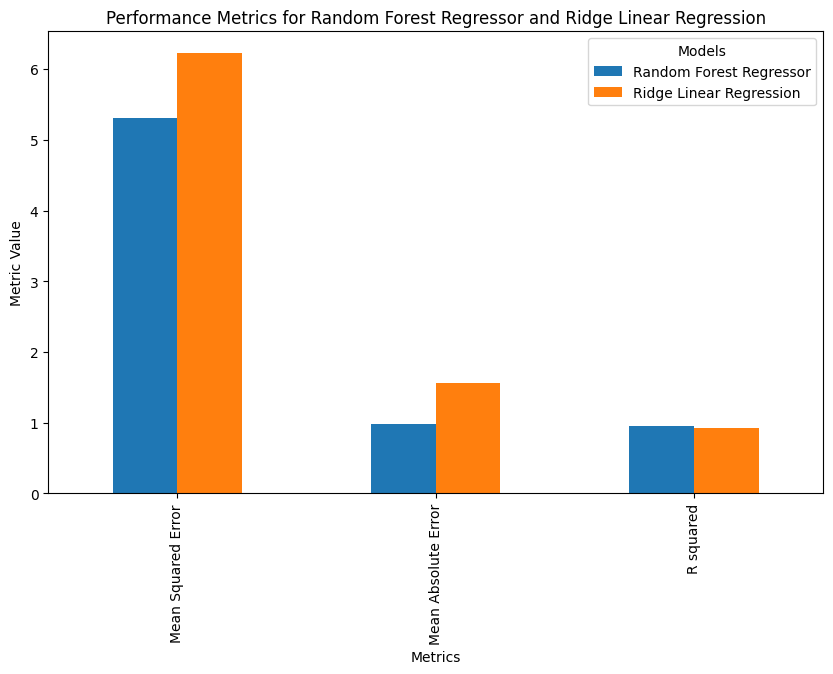

In [64]:
result_df.iloc[:3].plot(kind='bar', figsize=(10, 6))
plt.title('Performance Metrics for Random Forest Regressor and Ridge Linear Regression')
plt.ylabel('Metric Value')
plt.xlabel('Metrics')

plt.legend(title='Models')

plt.show()

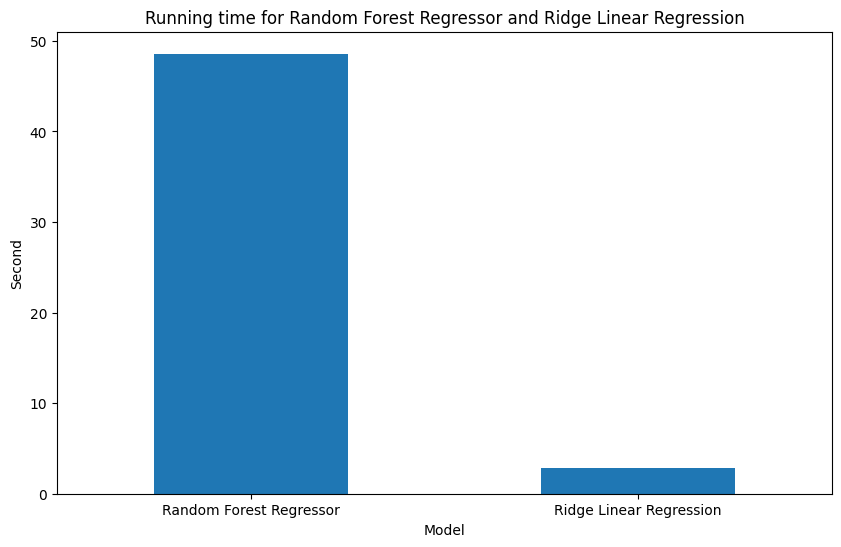

In [65]:
result_df.iloc[-1].plot(kind='bar', figsize=(10, 6))
plt.title('Running time for Random Forest Regressor and Ridge Linear Regression')
plt.ylabel('Second')
plt.xlabel('Model')
plt.tick_params(axis='x',rotation =0)

plt.show()

**Observations**
- In 3 metrics , `Random Forest Regressor` has better performance than `Ridge Linear Regression`
- In the running time , the `Ridge Linear Regression` runs a lot faster than  `Random Forest Regressor`

## Conclusion

- It can be concluded that the models have successfully addressed the initial problem of predicting the performance of players.
- It can be observed that all models, including Random Forest Regressor, Ridge Linear Regression, Fully-connected models, yield very high accuracy results. However, the difference between the two machine learning models (Random Forest Regressor, Ridge Linear Regression) and deep learning models is not significant, but the processing time of the neural network models is much higher. 
- Therefore, it can be said that for the given problem, the Random Forest Regressor model produces the best results.